# XED data

In [1]:
import polars as pl
import os 
# get all files per country
path = "emotion-data/XED"
files = os.listdir(path)

In [2]:
df = pl.DataFrame()
schema = {"text":pl.String,
          "labels":pl.String,
         "language":pl.String}
for f in files:
    tmp = pl.read_csv(path+"/"+f, separator="\t",schema=schema, ignore_errors=True)
    lang = f.split("-")[0]
    tmp = tmp.with_columns(language=pl.Series([lang]*len(tmp)))
    if tmp.is_empty():
        df=tmp
    else:
        df=pl.concat([df,tmp],how="vertical")

In [3]:
df["labels"].unique()
df

text,labels,language
str,str,str
"""انهمخزي!""","""1, 4, 7""","""ar"""
"""انهالأفضل!""","""8""","""ar"""
"""- لا تكن مؤدب …","""1, 3, 8""","""ar"""
"""في حال رفض الس…","""1""","""ar"""
"""لكن ماذا عن ال…","""2, 7""","""ar"""
…,…,…
"""美國人民 我聽到了你們的聲音…","""8""","""zh"""
"""她很擅長她的工作""","""1, 3""","""zh"""
"""湯姆...""","""8""","""zh"""


In [4]:
# exclude languages not present in parlamint 4.0 dataset
# language codes by ISO 639 in parlamint
lang_codes = ["bs","bg","hr","cs","da","nl","en","et","fi","fr","de",
                 "hu","is","it","lv","el","no","pl","pt","ru","sr","sl",
                 "es","sv","tr","uk"]

# exclude langs
df = df.filter(pl.col("language").is_in(lang_codes))

In [5]:
# convert string labels to list and recode from 0 to n-1
df = df.with_columns(pl.col("labels").map_elements(lambda s: [int(x)-1 for x in s.split(",") if x.isdigit]))


In [9]:
def one_hot(lst):
    vec = [0]*8
    for cls in lst:
        vec[cls]=1
    return vec
    
df = df.with_columns(pl.col("labels").map_elements(lambda l: one_hot(l)))
df

text,labels,language
str,list[i64],str
"""Няма работа за…","[0, 0, … 0]","""bg"""
"""Ако нямаше наг…","[0, 0, … 0]","""bg"""
"""Защо не пием з…","[0, 1, … 0]","""bg"""
"""Не става.""","[0, 0, … 0]","""bg"""
"""А и са безполе…","[0, 0, … 0]","""bg"""
…,…,…
"""Dur, Onu tanıy…","[0, 0, … 0]","""tr"""
"""Vakıf fonu Jan…","[0, 0, … 0]","""tr"""
"""Bilmiyorum ama…","[0, 0, … 1]","""tr"""


In [12]:
df.filter(df.group_by(pl.col("labels")).len()>100)

thread '<unnamed>' panicked at crates/polars-core/src/chunked_array/comparison/mod.rs:637:9:
not implemented
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: not implemented

In [7]:
import pandas as pd

df = pd.DataFrame(df)

df.columns = ['text', 'labels', 'lang']

In [8]:
# convert string labels to list and recode from 0 to n-1
# df = df.with_columns(pl.col("labels").map_elements(lambda s: [[int(x)-1] for x in s.split(",") if x.isdigit]))
import numpy as np

def to_array(string):
    string = string.replace(" ", "")
    number_list = string.split(',')
    number_list = [int(num) for num in number_list]
    number_array = np.array(number_list)
    
    return number_array

df.labels = df['labels'].apply(to_array)
df

,text,labels,lang
0,Няма работа за нас.,[6],bg
1,Ако нямаше награда за главите ни щяхме да се м...,[4],bg
2,Защо не пием за добрите стари времена?,"[2, 5]",bg
3,Не става.,[3],bg
4,"А и са безполезни, Кид.",[6],bg
...,...,...,...
170912,"Dur, Onu tanıyorum.",[7],tr
170913,Vakıf fonu Jane' in ilk sırada olmasıyla nasıl...,[7],tr
170914,"Bilmiyorum ama şimdilik ondan kurtulduk, sonra...",[8],tr
170915,Son yirmi yıldır hayatta şansım hiç gülmedi.,[6],tr


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer


def one_hot_encoding(ds):
    mlb = MultiLabelBinarizer()
    ds = ds.join(pd.DataFrame(mlb.fit_transform(ds.pop('labels')),
                          columns=mlb.classes_,
                          index=ds.index))
    
    return ds

df = one_hot_encoding(df)



In [10]:
#df = df.with_columns(pl.col('text').map_elements(lambda x: len(x)).alias('len_text'))
df
# Compute the mean length
#mean_length = df.select(pl.col('StringLength').mean())
#df['len_text'].mean()

,text,lang,1,2,3,4,5,6,7,8
0,Няма работа за нас.,bg,0,0,0,0,0,1,0,0
1,Ако нямаше награда за главите ни щяхме да се м...,bg,0,0,0,1,0,0,0,0
2,Защо не пием за добрите стари времена?,bg,0,1,0,0,1,0,0,0
3,Не става.,bg,0,0,1,0,0,0,0,0
4,"А и са безполезни, Кид.",bg,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
170912,"Dur, Onu tanıyorum.",tr,0,0,0,0,0,0,1,0
170913,Vakıf fonu Jane' in ilk sırada olmasıyla nasıl...,tr,0,0,0,0,0,0,1,0
170914,"Bilmiyorum ama şimdilik ondan kurtulduk, sonra...",tr,0,0,0,0,0,0,0,1
170915,Son yirmi yıldır hayatta şansım hiç gülmedi.,tr,0,0,0,0,0,1,0,0


In [11]:
# collapse one-hot columns into listdf
pl_df = pl.from_pandas(df)

In [ ]:
labels = []
for r in pl_df.iter_rows():
    labels.append(list(r[-8:]))

In [ ]:
labels

In [29]:
# delete combinations with less than 100 instances
#labels = df[['1', '2', '3', '4', '5', '6', '7', '8']]
#print( )
#labels_vectors = labels.values.tolist()

df.columns = ['text', 'lang', '1', '2', '3', '4', '5', '6', '7', '8']

In [30]:
freqs = list()

for i in range(1,9):
    freqs.append(df[str(i)].sum())
    print(i, df[str(i)].sum())
    


1 43095
2 38058
3 21538
4 25621
5 28559
6 26533
7 27320
8 28728


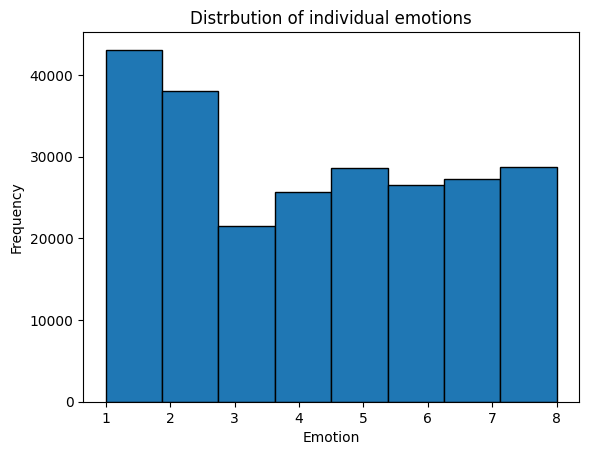

In [31]:
import matplotlib.pyplot as plt

values = []
for i, freq in enumerate(freqs):
    values.extend([i+1] * freq)  # i+1 to match the value (1, 2, 3, 4, 5)

# Step 3: Create a pandas DataFrame
df = pd.DataFrame(values, columns=['Value'])

# Step 4: Plot the histogram
plt.hist(df['Value'], bins=len(freqs), edgecolor='black')

# Customizing the histogram
plt.title('Distrbution of individual emotions')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(range(1, len(freqs) + 1))

# Show the plot
plt.show()

In [125]:
from collections import defaultdict

d = defaultdict(int)

for _, r in df.iterrows():
    dat = list(r)[2:10]
    d[tuple(dat)] += 1

In [127]:
for k in sorted(d, key = d.get, reverse=True):
    print(k, d[k])

(1, 0, 0, 0, 0, 0, 0, 0) 28288
(0, 1, 0, 0, 0, 0, 0, 0) 23252
(0, 0, 0, 0, 0, 0, 1, 0) 16253
(0, 0, 0, 0, 0, 0, 0, 1) 16048
(0, 0, 0, 1, 0, 0, 0, 0) 15876
(0, 0, 0, 0, 0, 1, 0, 0) 15721
(0, 0, 0, 0, 1, 0, 0, 0) 15381
(0, 0, 1, 0, 0, 0, 0, 0) 10293
(1, 0, 1, 0, 0, 0, 0, 0) 7197
(0, 0, 0, 0, 1, 0, 0, 1) 6070
(0, 1, 0, 0, 1, 0, 0, 0) 5519
(0, 1, 0, 0, 0, 0, 0, 1) 3449
(0, 0, 0, 0, 0, 1, 1, 0) 3156
(1, 1, 0, 0, 0, 0, 0, 0) 3020
(0, 0, 0, 1, 0, 1, 0, 0) 2376
(0, 0, 1, 0, 0, 1, 0, 0) 2015
(1, 0, 0, 1, 0, 0, 0, 0) 1944
(1, 0, 0, 0, 0, 0, 1, 0) 1936
(1, 0, 0, 0, 0, 1, 0, 0) 1932
(0, 0, 0, 0, 1, 0, 1, 0) 1841
(0, 1, 0, 0, 1, 0, 0, 1) 1835
(0, 1, 0, 0, 0, 0, 1, 0) 1789
(0, 1, 0, 1, 0, 0, 0, 0) 1730
(0, 0, 0, 1, 0, 0, 1, 0) 1535
(0, 0, 0, 1, 0, 0, 0, 1) 1427
(1, 0, 1, 0, 0, 1, 0, 0) 1044
(1, 0, 0, 0, 0, 0, 0, 1) 777
(0, 0, 0, 0, 0, 1, 0, 1) 649
(0, 1, 0, 0, 1, 0, 1, 0) 618
(0, 0, 0, 0, 0, 0, 1, 1) 586
(1, 0, 1, 0, 0, 0, 1, 0) 564
(0, 1, 0, 0, 0, 1, 0, 0) 537
(1, 0, 1, 1, 0, 0, 0, 0) 535
(0, 0, 1,

In [128]:
len(d)

224

## Modeling

In [ ]:
id2labels = {'0':"anger",
            '1':"anticipation",
              '2':"disgust",
              '3':"fear",
              '4':"joy",
              '5':"sadness",
              '6':"surprise",
              '7':"trust",
             }

# change order key value to recode through retrieval
labels2id = {v:k for k,v in labels_xed.items()}